In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df=pd.read_csv('Nat_Gas.csv')
df['Dates'] = pd.to_datetime(df['Dates'], format="%m/%d/%y").dt.strftime("%b-%Y")
df = df.reset_index()

# Rename column properly
df.rename(columns={'index': 'Date'}, inplace=True)



df.head()

,Date,Dates,Prices
0,0,Oct-2020,10.1
1,1,Nov-2020,10.3
2,2,Dec-2020,11.0
3,3,Jan-2021,10.9
4,4,Feb-2021,10.9


C:\Users\rumee\AppData\Local\Temp\ipykernel_32244\3369989095.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Dates'] = pd.to_datetime(df['Dates'])


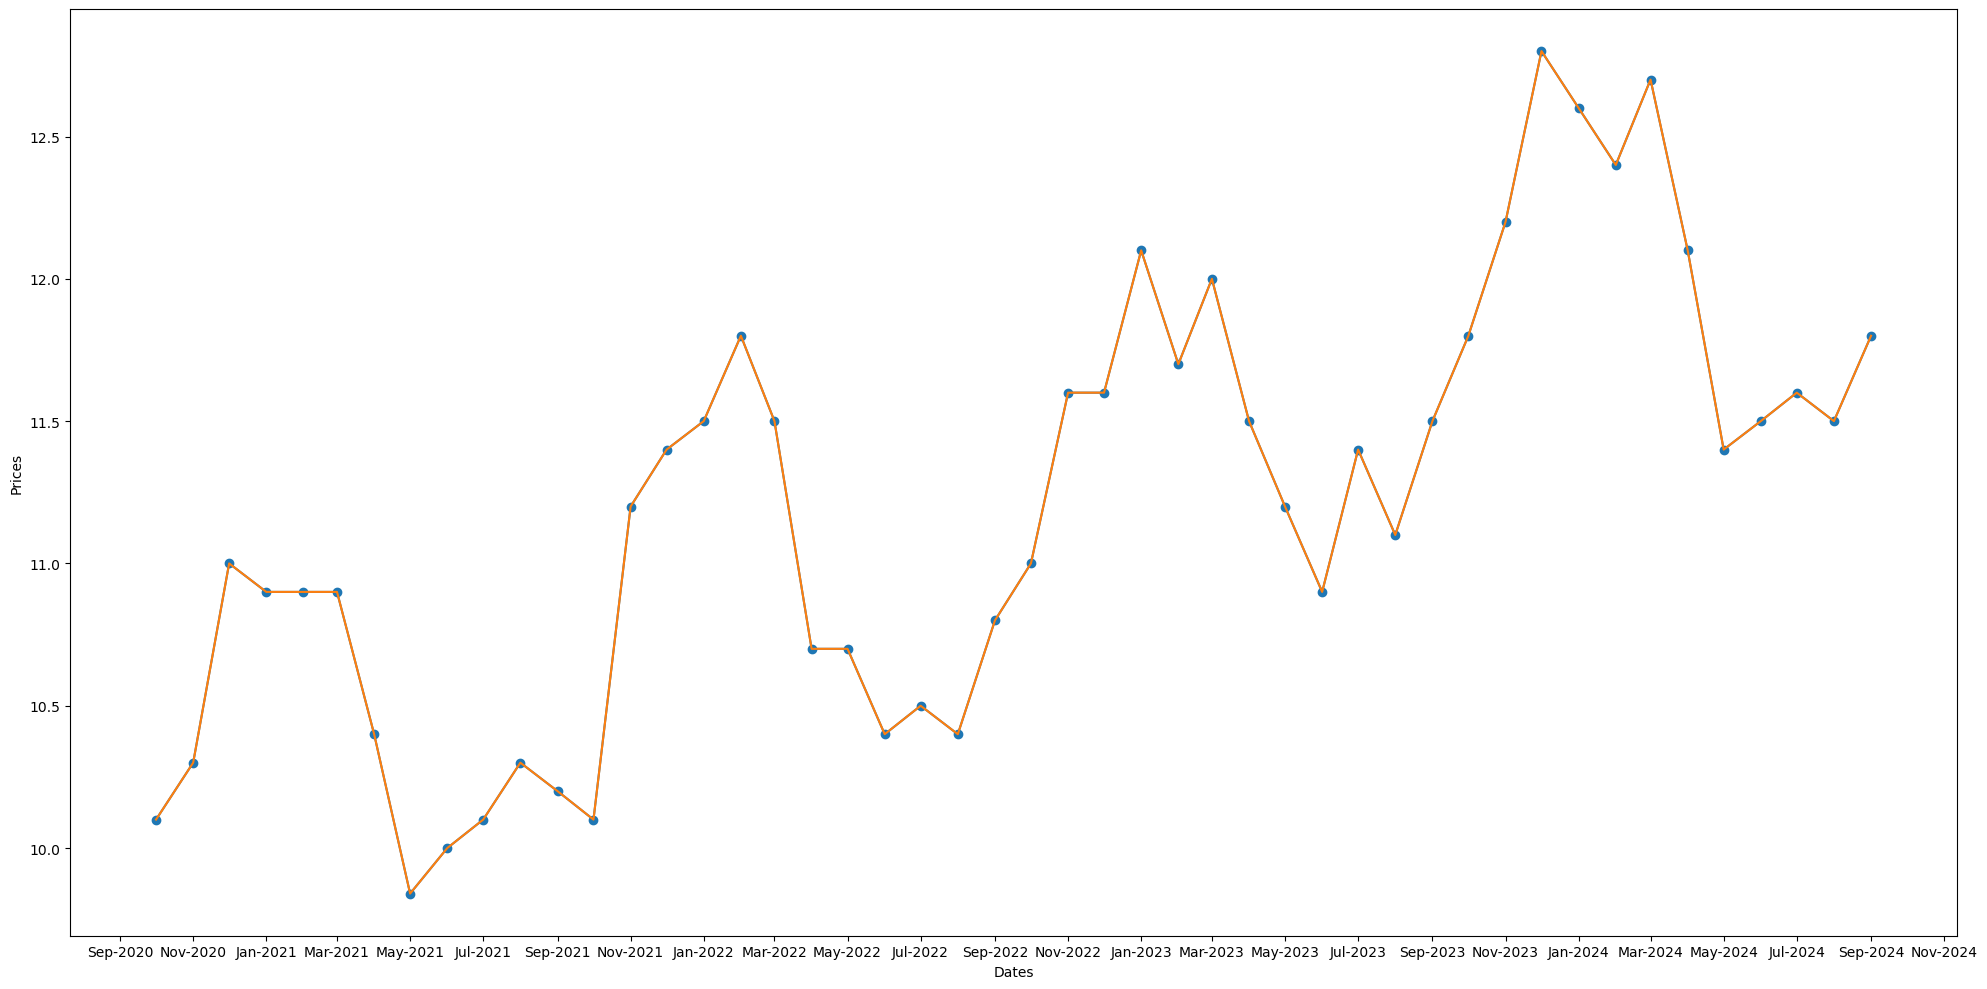

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Make sure Dates are proper datetimes
df['Dates'] = pd.to_datetime(df['Dates'])

# Plot
plt.figure(figsize=(20,10))
plt.plot(df['Dates'],df['Prices'],marker='o')
sns.lineplot(y=df['Prices'], x=df['Dates'])

# Format x-axis: show every 6 months
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))


plt.tight_layout()
plt.show()

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model


In [5]:
# 1) Ensure proper datetime index
df['Dates'] = pd.to_datetime(df['Dates'], format="%m/%d/%y")
df = df[df['Dates'] >= "2020-09-01"].sort_values('Dates')
df = df.set_index('Dates')

In [6]:
# --- 2) Reverse the series ---
rev_series = df['Prices'][::-1]  # reverse time order

In [7]:
# --- 3) Fit SARIMA on reversed data ---
mod_rev = SARIMAX(rev_series, order=(1,1,1), seasonal_order=(1,1,1,12))
res_rev = mod_rev.fit(disp=False)

C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too f

In [8]:
# --- 4) Forecast forward on reversed data ( = backward in real time ) ---
steps_back = 24
rev_forecast = res_rev.get_forecast(steps=steps_back)
rev_forecast_mean = rev_forecast.predicted_mean

C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [9]:
# Re-reverse back into original timeline
past_index = pd.date_range(end=df.index[0] - pd.offsets.MonthBegin(1), periods=steps_back, freq="MS")
past_forecast = pd.Series(rev_forecast_mean.values[::-1], index=past_index)

In [10]:
# --- 5) Forward forecast on original model ---
mod_fwd = SARIMAX(df['Prices'], order=(1,1,1), seasonal_order=(1,1,1,12))
res_fwd = mod_fwd.fit(disp=False)
steps_forward = 24
future_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=steps_forward, freq="MS")
future_forecast = res_fwd.get_forecast(steps=steps_forward).predicted_mean
future_forecast = pd.Series(future_forecast.values, index=future_index)

C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


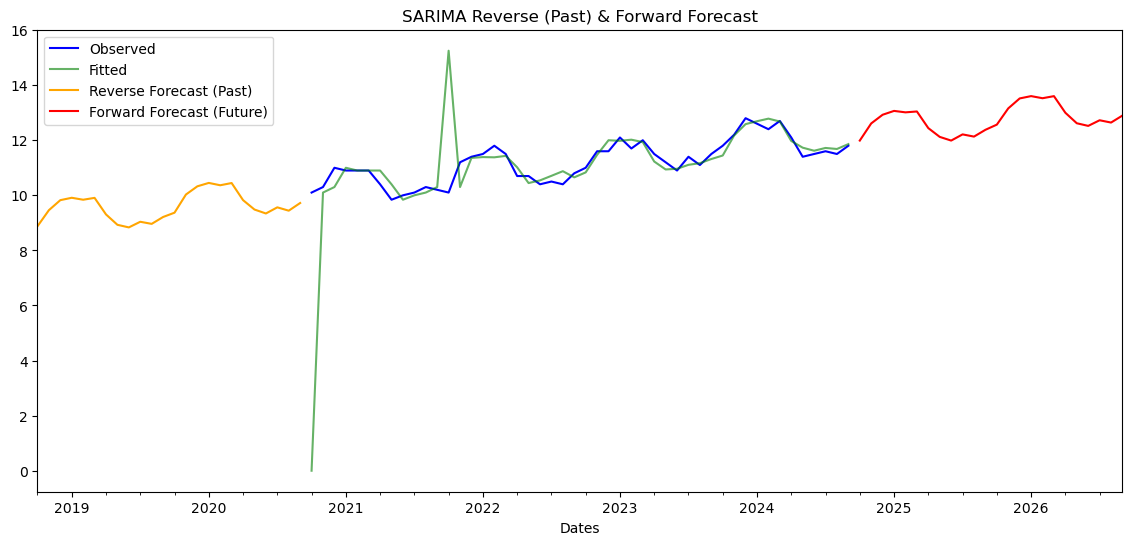

In [11]:
# --- 6) Plot ---
plt.figure(figsize=(14,6))
df['Prices'].plot(label='Observed', color="blue")
res_fwd.fittedvalues.plot(label="Fitted", color="green", alpha=0.6)
past_forecast.plot(label="Reverse Forecast (Past)", color="orange")
future_forecast.plot(label="Forward Forecast (Future)", color="red")

plt.title("SARIMA Reverse (Past) & Forward Forecast")
plt.legend()
plt.show()

In [12]:
df = df.reset_index()

# Rename column properly
df.rename(columns={'index': 'S.no.'}, inplace=True)

print(df.head())


       Dates  Date  Prices
0 2020-10-01     0    10.1
1 2020-11-01     1    10.3
2 2020-12-01     2    11.0
3 2021-01-01     3    10.9
4 2021-02-01     4    10.9


In [13]:

# Method 1: Using .iloc
first_value = df['Dates'].iloc[0]



In [14]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Fixed first date
date1 = datetime(2018, 9, 1)   # Sept-18

# Take user input for second date (format: Mon-YY, e.g. "Oct-20")
user_input = input("Enter a date (e.g., Oct-20): ")





Enter a date (e.g., Oct-20):  Dec-27


In [15]:
De
    start_date = datetime.strptime(start_date_str, "%b-%y")
    end_date = datetime.strptime(end_date_str, "%b-%y")
    
    if input_date < start_date:
        steps = month_difference(input_date, start_date)
    elif input_date > end_date:
        steps = month_difference(input_date, end_date)
    else:
        steps = 0
    return steps


# Convert to datetime using "%b-%y"
start_date = df['Dates'].iloc[0].strftime("%b-%y")
end_date= df['Dates'].iloc[47].strftime("%b-%y")


print(calculate_month_steps(user_input, start_date, end_date))  # Output: -1 (before start)
step=calculate_month_steps(user_input, start_date, end_date)

39


In [16]:
df['Dates'] = pd.to_datetime(df['Dates'], format="%m/%d/%y")
df = df[df['Dates'] >= "2020-09-01"].sort_values('Dates')
df = df.set_index('Dates')

In [17]:
# --- 2) Reverse the series ---
rev_series = df['Prices'][::-1]  # reverse time order

In [18]:
# --- 3) Fit SARIMA on reversed data ---
mod_rev = SARIMAX(rev_series, order=(1,1,1), seasonal_order=(1,1,1,12))
res_rev = mod_rev.fit(disp=False)

C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too f

In [19]:
# --- 4) Forecast forward on reversed data ( = backward in real time ) ---
if step<0:
    steps_back = -step
    rev_forecast = res_rev.get_forecast(steps=steps_back)
    rev_forecast_mean = rev_forecast.predicted_mean

In [20]:
past_index = pd.date_range(end=df.index[0] - pd.offsets.MonthBegin(1), periods=steps_back, freq="MS")
past_forecast = pd.Series(rev_forecast_mean.values[::-1], index=past_index)

In [21]:
# --- 5) Forward forecast on original model ---
mod_fwd = SARIMAX(df['Prices'], order=(1,1,1), seasonal_order=(1,1,1,12))
res_fwd = mod_fwd.fit(disp=False)
if step>0:
    steps_forward = step
    future_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=steps_forward, freq="MS")
    future_forecast = res_fwd.get_forecast(steps=steps_forward).predicted_mean
    future_forecast = pd.Series(future_forecast.values, index=future_index)

C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\rumee\anaconda3_new\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


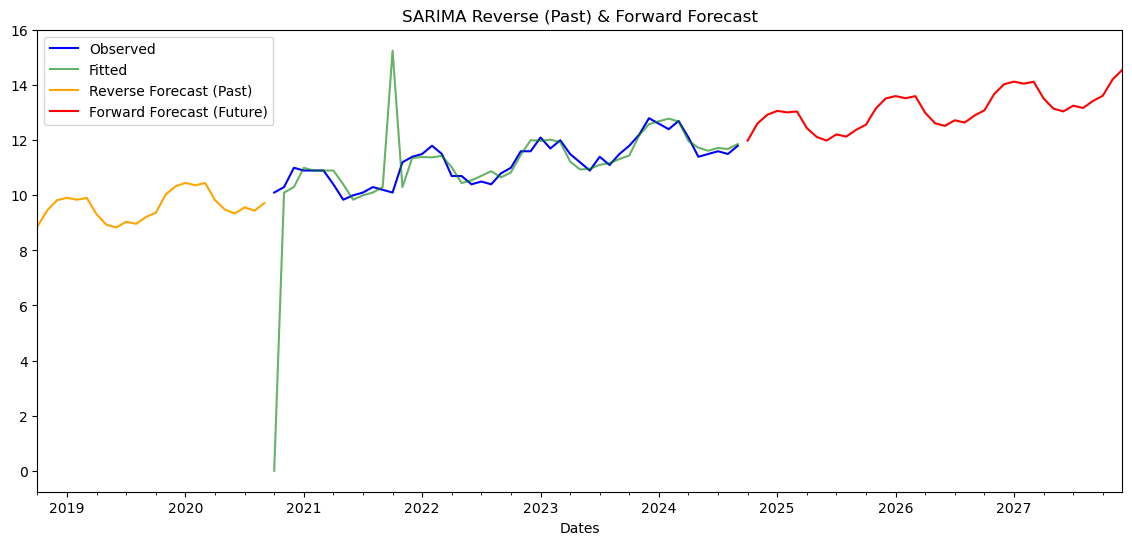

In [22]:
# --- 6) Plot ---
plt.figure(figsize=(14,6))
df['Prices'].plot(label='Observed', color="blue")
res_fwd.fittedvalues.plot(label="Fitted", color="green", alpha=0.6)
past_forecast.plot(label="Reverse Forecast (Past)", color="orange")
future_forecast.plot(label="Forward Forecast (Future)", color="red")

plt.title("SARIMA Reverse (Past) & Forward Forecast")
plt.legend()
plt.show()

In [23]:
if step>0:
    print("Predicted value=",future_forecast[step-1])

Predicted value= 14.56237029109905


C:\Users\rumee\AppData\Local\Temp\ipykernel_32244\3857889219.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Predicted value=",future_forecast[step-1])


In [24]:
if step<0:
    print("Predicted value=",past_forecast[0])

In [25]:
if step==0:
    print("No prediction required")